In [78]:
import numpy as np
import sys
import os
sys.path.append('../')
import base as base
import path_analysis
from path_analysis import straightness_over_time
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

In [134]:
# Adding function for bootstrapping to test/modify - now same as one in path_analysis
def bootstrap(trajectory,
              time_window=2,
              num_sampling=10,
              sample_rate=100,
              straightness_type='sliding'):
    
    print('BOOTSTRAPPING SAMPLES...')
    ##trajectory = [time,x,y,z]
    ## sample sham trajectory from entire session randomly
    sham_straightness_list = []
    shuffle_count = 0
    
    while shuffle_count < num_sampling:
        random_index = np.random.randint(0, len(trajectory))
        
        # Take all the times following the random index
        time = trajectory[random_index:, 0]
        
        # This outputs an array like [1, 2, 3, .... FINAL TIME PT after random idx]
        time_cum = np.cumsum(time[1:] - time[:-1])       

        if time_cum[-1] > time_window:
            end_index = np.where(time_cum > time_window)[0][0]
            shuffle_count += 1

        else:
            continue
        sampled_trajectory = trajectory[random_index:random_index + end_index + 100]
        
        if straightness_type == 'sliding':
            sham_straightness = straightness_over_time(
                sampled_trajectory, time_window)[0]

        elif straightness_type == 'fixed':
            sham_straightness = straightness_moment_time(
                sampled_trajectory, time_window)[0]

        sham_straightness_list.append(sham_straightness)
    return sham_straightness_list

In [5]:
# Data source
root = '/mnt/c/Users/megla/OneDrive/Documents/TUM/RatAnalysis/Multiple_trial_analysis/Data/Raw/FS10/BPositions_FS10_20211006-154014'
tag = '20211006-154014'

In [27]:
pos_file = [os.path.join(root, f) for f in os.listdir(root) if 'position' in f][0]
FS10_position = pd.read_csv(pos_file, sep=" ", header=None).to_numpy()

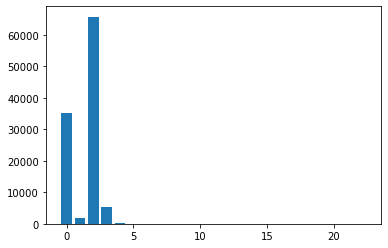

0.019999980926513672


In [97]:
pos_timeseries = FS10_position[:,0]
time_diffs = np.diff(pos_timeseries)
unique_steps, counts = np.unique(time_diffs, return_counts=True)

plt.bar(np.arange(len(unique_steps)), height=counts)
plt.show()

print(unique_steps[np.argmax(counts)])

In [82]:
len(pos_timeseries)
print(pos_timeseries[0])

1633527626.49


In [128]:
time_step = unique_steps[np.argmax(counts)]
even_spaced_time = np.arange(pos_timeseries[0], pos_timeseries[-1], time_step)

pos_x = FS10_position[:,1]
pos_y = FS10_position[:,3]

interp_func_x = interp1d(pos_timeseries, pos_x)
interp_func_y = interp1d(pos_timeseries, pos_y)

interp_x = interp_func_x(even_spaced_time)
interp_y = interp_func_y(even_spaced_time)

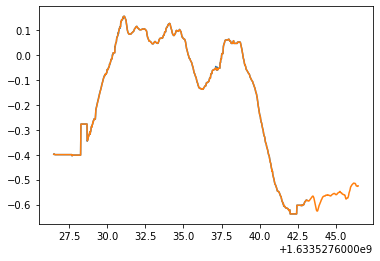

In [129]:
t_test = 1000

plt.plot(pos_timeseries[:t_test], pos_x[:t_test])
plt.plot(even_spaced_time[:t_test], interp_x[:t_test])
plt.show()

In [130]:
interp_full = np.concatenate((np.expand_dims(even_spaced_time, axis=0), 
                              np.expand_dims(interp_x, axis=0), 
                              np.expand_dims(interp_y, axis=0))).T

In [131]:
# PARAMS
N_SAMPLES = 1000
WIN_SIZE = 3
STRAIGHT_TYPE = 'sliding'

bootstrapped_segments = bootstrap(interp_full, time_window=WIN_SIZE, 
                                  num_sampling=N_SAMPLES, 
                                  straightness_type=STRAIGHT_TYPE)

BOOTSTRAPPING SAMPLES...


/mnt/c/Users/megla/OneDrive/Documents/TUM/RatAnalysis/Multiple_trial_analysis/refactoring/demo_notebook/../path_analysis.py:89: RuntimeWarning: invalid value encountered in double_scalars
  straightness.append(straight_length / trajectory_displacement)


In [132]:
bootstrap_arr = np.array(bootstrapped_segments)
print(bootstrap_arr.shape)

(1000, 148)


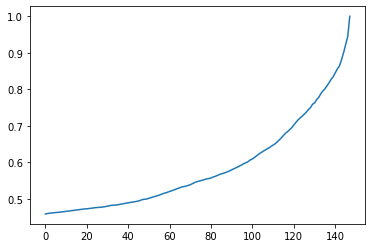

In [133]:
average_boot = np.nanmean(bootstrap_arr,axis=0)

plt.plot(average_boot)
plt.show()